<a href="https://colab.research.google.com/github/rekalantar/CT_3DLungSegmentation/blob/master/3DLungSegmentation_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Lung CT segmentation is the process of identifying and separating the lung tissue in a CT scan image. This is an important task in the field of medical imaging, as it allows for more accurate diagnosis and treatment planning for lung diseases such as lung cancer, chronic obstructive pulmonary disease (COPD), and pneumonia.

Accurate segmentation of the lungs in a CT scan can help radiologists identify and measure the size and location of tumors or other abnormalities within the lungs. This information can be used to guide the placement of biopsy needles or radiation therapy beams, and to monitor the progression of diseases over time.

Additionally, lung CT segmentation can also be used to automatically extract quantitative information such as lung volumes and airway measurements, which can be used to aid in the diagnosis and treatment of lung diseases.

Furthermore, in the field of machine learning, lung CT segmentation is used as a pre-processing step for many medical image analysis tasks, such as nodule detection, classification, and registration.

In summary, lung CT segmentation is an essential task in medical imaging that can help improve the accuracy of diagnoses and treatment planning for lung diseases, and also provide important information for machine learning models.

**Download Dataset from Kaggle**

In this section, we will learn how to download a dataset from Kaggle in Google Colab.

First, we will install the Kaggle library by running the following command:

In [126]:
!pip install -q kaggle

Next, we will create a directory called ".kaggle" in the root directory by running:

In [127]:
!mkdir -p ~/.kaggle

We will then upload our Kaggle API token. This token can be obtained from the Kaggle website and is required to access Kaggle datasets ([click here for more information](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab)). To upload the token, we will run the following commands:

In [125]:
from google.colab import files
files.upload() # upload your Kaggle.json API token

{}

Once the token is uploaded, it must be placed in the ".kaggle" directory by running:

In [128]:
!cp kaggle.json ~/.kaggle/

With the setup done, we can now download a dataset. In this example, we will download the "finding-lungs-in-ct-data" dataset by running the following command:

In [129]:
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

finding-lungs-in-ct-data.zip: Skipping, found more recently modified local copy (use --force to force download)


Finally, we will unzip the downloaded dataset by running:

In [130]:
!unzip /content/finding-lungs-in-ct-data.zip

Archive:  /content/finding-lungs-in-ct-data.zip
replace 2d_images.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Import Libraries**

In [9]:
import os
import glob
import torch
import numpy as np 
import nibabel as nib

import matplotlib.pyplot as plt
%matplotlib inline

**Visualize Data**

With the dataset downloaded and ready, we can now proceed to load, visualize, and analyze it. This is done by reading the image and label files in the nifti format and inspecting the data by printing the image shapes and intensity ranges. Additionally, we can visualize the data to gain a better understanding of its characteristics.

In [40]:
data_dir = '/content/3d_images'
images = sorted(
    glob.glob(os.path.join(data_dir, "IMG*.nii.gz")))
labels = sorted(
    glob.glob(os.path.join(data_dir, "MASK*.nii.gz")))

print('No. of images:', len(images), ' labels:', len(labels))

No. of images: 4  labels: 4


img shape: (325, 512, 512)  lbl shape: (325, 512, 512)
img intensity min.: -933.0  max.: 2675.0  unique labels: [  0. 255.]


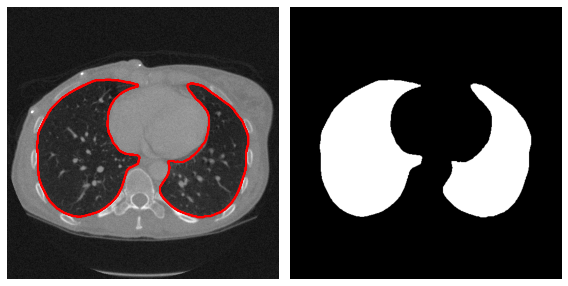

In [3]:
img = nib.load(images[0]).get_fdata()
lbl = nib.load(labels[0]).get_fdata()
print('img shape:', img.shape, ' lbl shape:', lbl.shape)
print('img intensity min.:', np.min(img), ' max.:', np.max(img), ' unique labels:', np.unique(lbl))

slice_idx = 100
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx], cmap='gray', vmin=-1000, vmax=1000)
plt.contour(lbl[slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

**Set Determinism for Reproducibility of Results**

In this tutorial, we use the MONAI library, a popular open-source library for medical imaging. We start by installing the library and set a seed for determinism. The set_determinism function from the monai.utils module, allows us to set the seed for random number generation, which ensures that the model training process is deterministic and reproducible.

In [10]:
!pip install monai
from monai.utils import first, set_determinism

set_determinism(seed=0)

Next, we define a dict that includes image and label paths for each patient. As this dataset contains only 4 patients, we use 2, 1 and 1 patients for training, validation and testing respectively.

In [4]:
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]

train_files, val_files, test_files = data_dicts[:2], data_dicts[2:3], data_dicts[-1:]

print('train files:', len(train_files), ' val files:', len(val_files), ' test files:', len(test_files))


train files: 2  val files: 1  test files: 1


**Define Transforms for Preprocessing**

The following code is responsible for defining image preprocessing transforms for the training and validation sets. The "Compose" function is used to create two pipelines of transform functions. One for training set and one for validation set. One of the key transformations used is "RandSpatialCropd", which randomly selects cubic patches of size (96, 96, 96) from the training image and label volumes.

Patch-based training offers several benefits. It provides more data for training the segmentation framework, incorporates spatial information that would otherwise be ignored in 2D training, and results in improved final outcome consistency by using results from multiple patches. The training transformations include various data augmentation techniques such as random spatial cropping, rotation, scaling, flipping, and intensity shift and scaling. The validation transformations, on the other hand, only perform basic preprocessing.

This code is essential in preparing the data for stochastic model training and validation by applying necessary preprocessing steps to the images. It also allows for easy modification of the data augmentation steps depending on the task and dataset.

In [14]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        
        # Change labels from 255 to 1
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        
        # Randomly crop a patch from both image and label files
        RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[96, 96, 96],
                random_size=False,
        ),
     
        # Data augmentation transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=2),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ])

We can now visualize a sample patch from our training dataset.

img shape: torch.Size([96, 96, 96]), lbl shape: torch.Size([96, 96, 96])


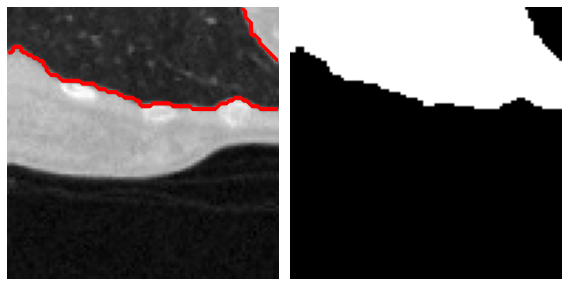

In [13]:
sample_ds = Dataset(data=train_files, transform=train_transforms)
sample_dataloader = DataLoader(sample_ds, batch_size=1)
sample_batch = first(sample_dataloader)

img, lbl = sample_batch["image"][0][0], sample_batch["label"][0][0]
print(f"img shape: {img.shape}, lbl shape: {lbl.shape}")

slice_idx = 64
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,slice_idx], cmap='gray')
plt.contour(lbl[:,:,slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[:,:,slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

Now, we create dataloaders for training and validation datasets using MONAI library. The CacheDataset class is used to create the training and validation datasets by specifying the file paths, the preprocessing transforms, the cache rate, and the number of workers for parallel processing. It is a class in the MONAI library that is used to create a dataset from a list of data files and a transform function. It can be used to cache the preprocessed data in memory for faster access during training, which can be particularly useful for large datasets.

In [15]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1)

Loading dataset: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


**Define Model, Loss Function and Optimizer**

This code defines and initializes the main components for training a 3D segmentation model using the MONAI library. The model is defined as an instance of the U-Net class, which is a popular architecture for image segmentation tasks. The loss function is DiceLoss, the optimizer is Adam, and the evaluation metric is DiceMetric. These components are essential for training and evaluating the performance of the model.

In [16]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Finally, we can train our model and evaluate its performance on the validation set using image volumes. By utilizing the sliding_window_inference algorithm, we can predict the masks from multiple patches within the image volume. To ensure the best performance, we save the weights from the epoch that yields the highest overall performance. We train our model for a total of 500 epochs.

In [18]:
from monai.inferers import sliding_window_inference

# Define hyperparameters
max_epochs = 500
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Define post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Training loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device),
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 1, model)

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/500
1/1, train_loss: 0.5529
epoch 1 average loss: 0.5529
----------
epoch 2/500
1/1, train_loss: 0.6032
epoch 2 average loss: 0.6032
saved new best metric model
current epoch: 2 current mean dice: 0.2767
best mean dice: 0.2767 at epoch: 2
----------
epoch 3/500
1/1, train_loss: 0.5319
epoch 3 average loss: 0.5319
----------
epoch 4/500
1/1, train_loss: 0.4883
epoch 4 average loss: 0.4883
current epoch: 4 current mean dice: 0.2767
best mean dice: 0.2767 at epoch: 2
----------
epoch 5/500
1/1, train_loss: 0.4486
epoch 5 average loss: 0.4486
----------
epoch 6/500
1/1, train_loss: 0.4851
epoch 6 average loss: 0.4851
saved new best metric model
current epoch: 6 current mean dice: 0.2768
best mean dice: 0.2768 at epoch: 6
----------
epoch 7/500
1/1, train_loss: 0.5605
epoch 7 average loss: 0.5605
----------
epoch 8/500
1/1, train_loss: 0.4320
epoch 8 average loss: 0.4320
saved new best metric model
current epoch: 8 current mean dice: 0.2777
best mean dice: 0.2777 at epoch

In [19]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9597 at epoch: 436


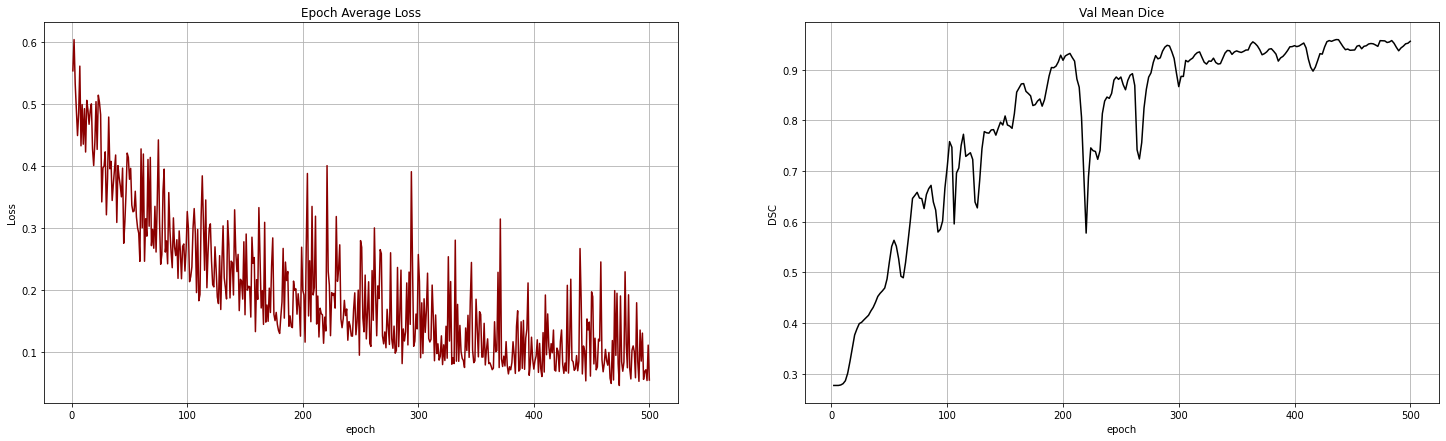

In [29]:
plt.figure("train", (25,7))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.plot(x, y, color='darkred')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.ylabel("DSC")
plt.xlabel("epoch")
plt.grid(True)
plt.plot(x, y, color='black')
plt.show()

**Make Predictions from Test Data**

This code is creating a test dataset, loading it and applying post-processing transforms on the data. It is created by using the "test_files" variable, which contains the file paths of the test images, and the "val_transforms" transformation, which applies pre-processing operations on the images. 

The post-processing transforms are defined using the "Compose" function. The "Invertd" function allows reverting the preprocessing steps and convert the predictions back to the original image spacing.

The next step is "AsDiscreted" transform that is a post-processing step for converting the image data into discrete values. Specifically, it applies the argmax method on the image data, which selects the class with the highest probability at each pixel/voxel. Then, the AsDiscreted transform converts the image data into one-hot format with 2 classes.

In [31]:
test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=val_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

With the trained model, we can now segment the lungs from the test data. We employ the sliding window inference technique with 75% patch overlap to predict the lung mask volume. Despite the limited training data, comprising of only 2 patients for training and 1 for validation, the model exhibits outstanding performance. However, it's worth noting that the limited training data may lead to overfitting, which can be mitigated by using transfer learning techniques to improve the model's performance and generalizability.

2023-01-14 21:29:19,166 INFO image_writer.py:194 - writing: out/IMG_0078/IMG_0078_seg.nii.gz


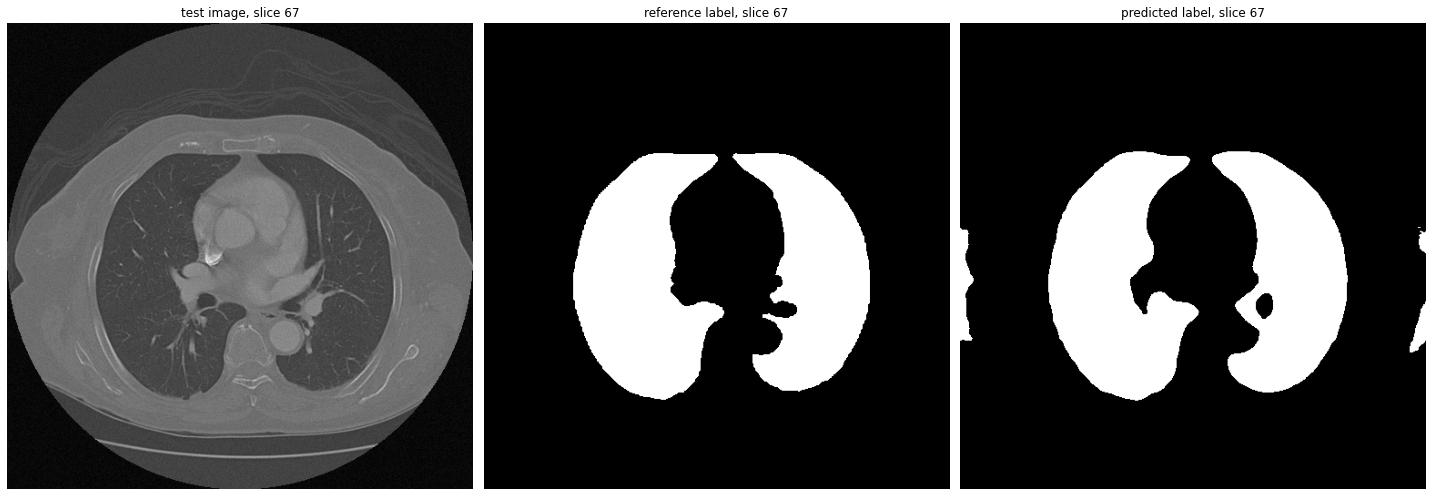

In [36]:
from monai.transforms import LoadImage
from monai.handlers.utils import from_engine

loader = LoadImage()

model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_files[0]['image'])[0] # Load the original image
        original_label = loader(test_files[0]['label'])[0] # Load the original label

        slice_idx = 67

        plt.figure(figsize=(20,7))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.title(f'test image, slice {slice_idx}')
        plt.imshow(original_image.detach().cpu().numpy()[slice_idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f'reference label, slice {slice_idx}')
        plt.axis('off')
        plt.imshow(original_label.detach().cpu().numpy()[slice_idx], cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title(f'predicted label, slice {slice_idx}')
        plt.axis('off')
        plt.imshow(test_output[0].detach().cpu().numpy()[1,slice_idx], cmap="gray") # use index 1 to get the lung class
        plt.tight_layout()
        plt.show()